In [4]:
from diffusers import DiffusionPipeline
import numpy as np
import random
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import torch
from diffusers import StableDiffusionPipeline

# Using 512x512 resolution
model_id = "stabilityai/stable-diffusion-2-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.safety_checker = None

/data/ap2619/diffusion/score_sde_pytorch/.venv_score/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-19 11:35:46.602781: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: module 'triton.language' has no attribute 'constexpr'
Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 7504.91it/s]


In [5]:
# Plotting
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [6]:
seed=1024
generator = torch.Generator("cuda").manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(0)
random.seed(0)

100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


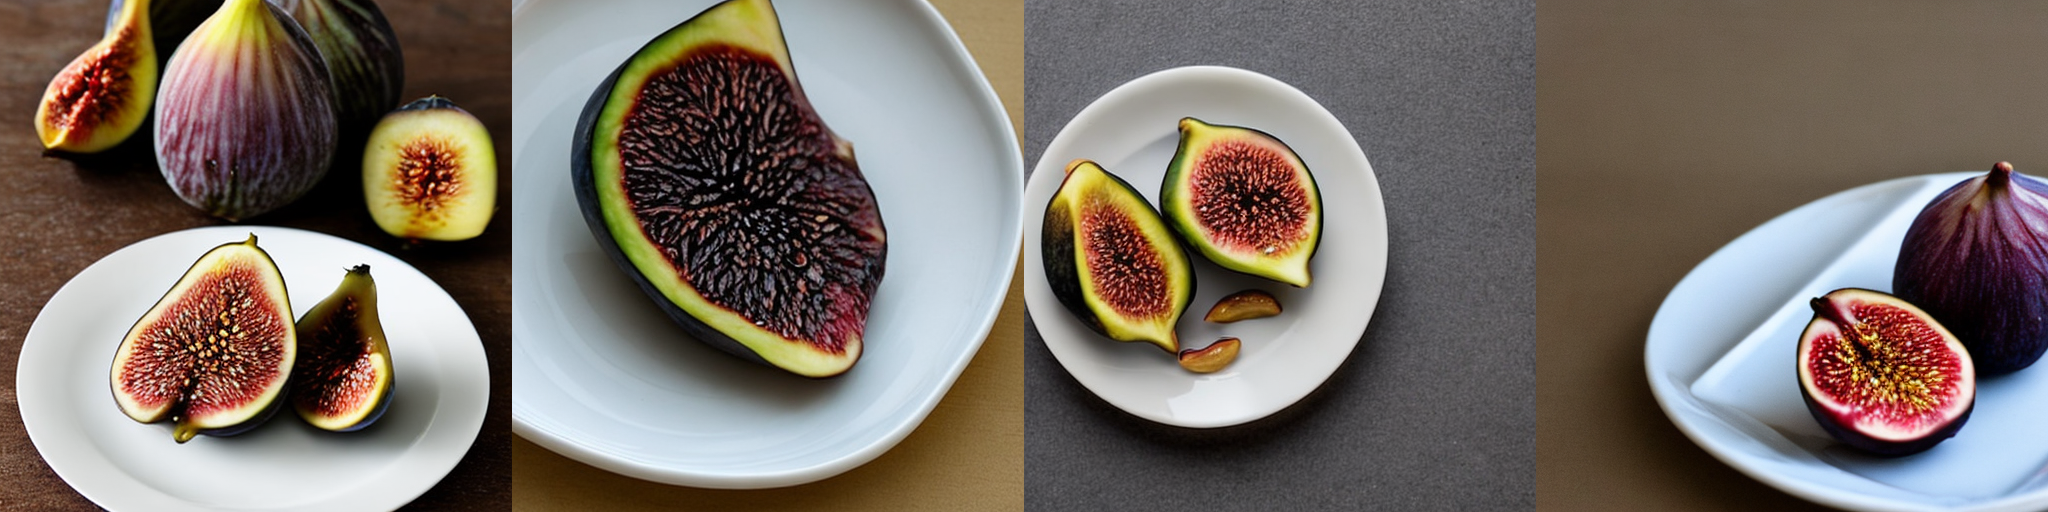

In [17]:
num_cols = 4
num_rows = 1

# prompt = ["full length shot, super hero pose, biomechanical suit, inflatable shapes, wearing epic bionic cyborg implants, masterpiece, intricate, biopunk futuristic wardrobe, highly detailed, artstation, concept art, cyberpunk, octane render"]
prompt = ["fig on a white plate"]

prompt = prompt* num_cols

all_images = []
for i in range(num_rows):
  images = pipe(prompt, num_inference_steps=20, generator=generator, guidance_scale=8).images
  all_images.extend(images)

grid = image_grid(all_images, rows=num_rows, cols=num_cols)
grid

Pipeline from scratch

In [ ]:
# List out all fruit
# Save all ["{fruit} on white plate"] into data folder
# Compute FID score or save encodings of Inception network

In [30]:
import yaml
with open("data/labels.yaml", 'r') as stream:
    labels = yaml.safe_load(stream)
with open("data/config.yaml", 'r') as stream:
    params = yaml.safe_load(stream)

In [33]:
for label in labels['fruit']:
    prompt = f"{label} on a white plate"
    filename = label.replace(" ", "_")
    dst_path = os.path.join("data","fruit", filename)
    os.makedirs(dst_path, exist_ok=True)
    print(label)
    for i in range(params['samples_per_class']):
        print(f"{filename}_{i}.png")
        img = pipe(prompt, 
                    num_inference_steps = params['num_steps'], 
                    guidance_scale = params['cfg'],
                    generator=generator).images[0]
        img.save(os.path.join(dst_path , f"{filename}_{i}.png"))

apple
apple_0.png


100%|██████████| 20/20 [00:01<00:00, 12.86it/s]


strawberry
strawberry_0.png


100%|██████████| 20/20 [00:01<00:00, 13.11it/s]


lemon
lemon_0.png


100%|██████████| 20/20 [00:01<00:00, 13.09it/s]


orange
orange_0.png


100%|██████████| 20/20 [00:01<00:00, 13.04it/s]


banana
banana_0.png


100%|██████████| 20/20 [00:01<00:00, 13.03it/s]


custard apple
custard_apple_0.png


100%|██████████| 20/20 [00:01<00:00, 13.00it/s]


fig
fig_0.png


100%|██████████| 20/20 [00:01<00:00, 12.95it/s]


jackfruit
jackfruit_0.png


100%|██████████| 20/20 [00:01<00:00, 12.92it/s]


pineapple
pineapple_0.png


100%|██████████| 20/20 [00:01<00:00, 12.89it/s]


pomegranate
pomegranate_0.png


100%|██████████| 20/20 [00:01<00:00, 12.87it/s]


In [52]:
# compute fid
from os import walk

f = []
data_path = os.path.join("data","fruit")
for category in os.listdir(data_path):
    f.extend(os.path.listdir(os.path.join(data_path,category)))
    # f.extend([os.path.join(data_path, filename) for filename in filenames])
    print(dirpath, dirnames, filenames)
    break

data/fruit ['apple', 'strawberry', 'lemon', 'orange', 'banana', 'custard_apple', 'fig', 'jackfruit', 'pineapple', 'pomegranate'] []


In [64]:
import glob
f = []
for file in glob.glob("data/fruit/*/*"):
    f.append(file)

In [81]:
f = []
for file in glob.glob("data/sample/apple/*"):
    f.append(file)

In [82]:
len(f)

1000

In [83]:
from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance
from fid.inception import InceptionV3

fid_dir = "fid" #/pt_inception-2015-12-05-6726825d.pth"
dims = 2048
device = 'cuda'
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx], model_dir=fid_dir).to(device)
m, s = calculate_activation_statistics(f[:10], model, 8, dims, device)

save_statistics("data/apple_sample_fid.npz",m,s)

# load precomputed m, s
# path = os.path.join(fid_dir, args.dataset + '.npz')
# m0, s0 = load_statistics(path)

# fid = calculate_frechet_distance(m0, s0, m, s)

/data/ap2619/diffusion/score_sde_pytorch/.venv_score/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/diffusion/score_sde_pytorch/.venv_score/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.


In [84]:
m, s = load_statistics("data/apple_sample_fid.npz")
m0, s0 = load_statistics("data/fruits_fid.npz")
fid = calculate_frechet_distance(m0, s0, m, s)

In [85]:
fid

179.99043529898492